# CE888 Assignment 2 for Demo

This code is written to demonstarte data analysis made for ce888 assignment 2.

**Author**          : Tomoko Ayakawa<br> 
**Created on**      : 29 March 2019<br> 
**Last modified on**: 4 April 2019<br> 

In [1]:
# import open source libraries
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys

# import original libraries
sys.path.append("../")

import utility as UTL
#import assignment1_main as MAIN
import load_data as DATA
import histogram as HST
from conf import myVariables as VAR
import correlation as CRRL
import pca as PCA
import classifier as CLS
import feature_importance as IMP

## 1. Load Data
Load data from **data** directory.<br>
Reading and preprocessing data into pandas.DataFrame are done by respective python files.<br>
#### Returned variables<br>
>`col_names` : List --- Name of the columns (including target column)<br>
`features_df` : DataFrame --- Feature values<br>
`targets_df` : DataFrame --- Target values<br>
`data_df` : DataFrame --- The whole data containing both features and targets<br>
`pic_file`: String --- Prefix for file name (data name + timestamp)<br>
`unique_labels` : List --- Column haeders containing feature names and terget name ("Class")
>

#### Select data to load (Argument `data_id`)
> 0. Human Activity
1. Spam
2. Phishing
>

In [2]:
data_list={0: "human activity", 1: "spam", 2: "phishing"}
data_id = int(input(data_list))

col_names, features_df, targets_df, data_df, pic_file = DATA.load_data(data_id=data_id)
unique_labels = DATA.verify_data(data_df, targets_df)

{0: 'human activity', 1: 'spam', 2: 'phishing'}0


./sub/load_data.py:52: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  data_df = data_df.convert_objects(convert_numeric=True)


Number of NaN: 0
Data shape:  (7352, 562)
Target labels: ['1' '2' '3' '4' '5' '6']
The range of features:                                                 Max       Min
1_tBodyAcc-mean()-X                       1.000000 -1.000000
2_tBodyAcc-mean()-Y                       1.000000 -1.000000
3_tBodyAcc-mean()-Z                       1.000000 -1.000000
4_tBodyAcc-std()-X                        1.000000 -1.000000
5_tBodyAcc-std()-Y                        0.916238 -0.999873
6_tBodyAcc-std()-Z                        1.000000 -1.000000
7_tBodyAcc-mad()-X                        1.000000 -1.000000
8_tBodyAcc-mad()-Y                        0.967664 -1.000000
9_tBodyAcc-mad()-Z                        1.000000 -1.000000
10_tBodyAcc-max()-X                       1.000000 -1.000000
11_tBodyAcc-max()-Y                       1.000000 -1.000000
12_tBodyAcc-max()-Z                       1.000000 -1.000000
13_tBodyAcc-min()-X                       1.000000 -1.000000
14_tBodyAcc-min()-Y                    

In [ ]:
#display the first 5 rows of the selected data
data_df.head(5)

## 2. Pre-process the data
### 2-1. Obtain the small data
`get_small_data` returns the specified number of samples. <br>
If `min_samples` is **None**, then **50 + 8\*num_cols** samples will be returned.

In [5]:
min_samples=int(input("Enter the number of samples to use (Total: %d): " % data_df.shape[0]))
features, classes=UTL.get_small_data(data_df.values, targets_df.values, min_samples=min_samples)

Enter the number of samples to use (Total: 7352): 100
ratio: 0.013601741022850925
Minimul size of the data for 562 features: 100
The size of the data used for classification: 100


### 2-2. Fit the scaler and transform the data

In [9]:
def pre_processing(X, mode):   
    from sklearn.preprocessing import \
        MinMaxScaler, QuantileTransformer, StandardScaler
    
    # fit the scalar
    if mode==0:
        scl=None
        X_nrm=X
    else:
        if mode==1: scl=MinMaxScaler()
        if mode==2: scl=QuantileTransformer(output_distribution="normal")
        if mode==3: scl=StandardScaler()
        scl.fit(X)
        X_nrm=scl.transform(X)
    
    print("Scaler:", scl)
    
    return scl, X_nrm

In [93]:
scaler=int(input("Select the scaler 0 (None), 1 (MinMax), 2 (Quantile), 3 (Standard): "))

scl_features, features_nrm=pre_processing(features, scaler)
features_nrm[:5]

Select the scaler 0 (None), 1 (MinMax), 2 (Quantile), 3 (Standard): 0
Scaler: None


array([[ 0.2301819 , -0.03903564, -0.06595503, ..., -0.33675597,
        -0.65147245,  6.        ],
       [ 0.18817546, -0.03356478, -0.09779167, ...,  0.16044214,
         0.01485896,  3.        ],
       [ 0.26902148, -0.01668537, -0.1085458 , ..., -0.89608056,
        -0.09523919,  6.        ],
       [ 0.33584724,  0.01144556, -0.08003737, ...,  0.28283857,
         0.08020741,  3.        ],
       [ 0.26001824, -0.00849105, -0.11758838, ...,  0.11375537,
         0.10016997,  4.        ]])

### 2-3. Check the distribution of pre-processed data

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


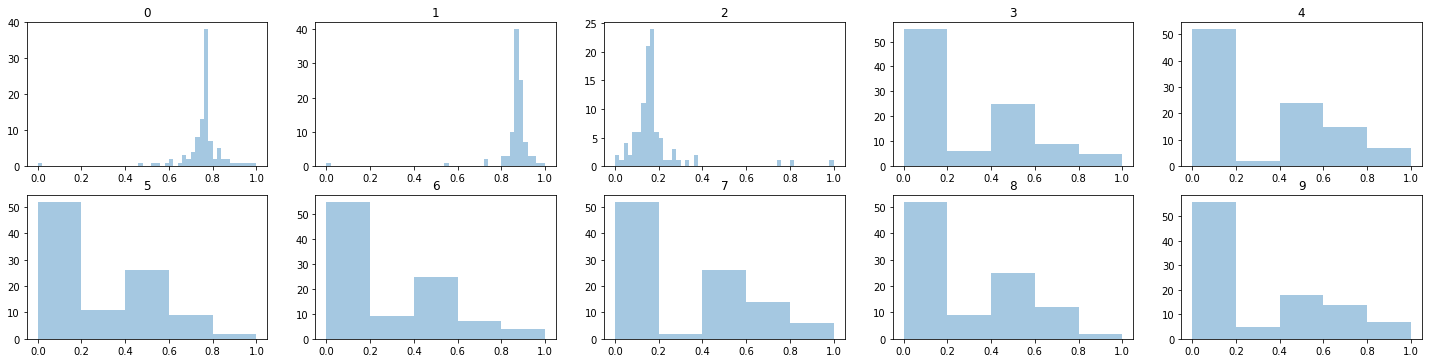

In [13]:
pic_file="test"
nrm_pd=pd.DataFrame(features_nrm)
HST.histogram(nrm_pd[nrm_pd.columns[:10]], pic_file, "_features")

## 3. Split the training dataset

In [94]:
def split_data(X, y, test_size=0.2):
    from sklearn.model_selection import train_test_split
    
    X_tr, X_te, Y_tr, Y_te=train_test_split(X, y, test_size=test_size)
    print("Training: %d, Test: %d" % (len(X_tr), len(X_te)))
    
    return X_tr, X_te, Y_tr, Y_te

In [200]:
test_size=float(input("Enter the test_size (0<test_size<1): "))
feat_tr, feat_te, cls_tr, cls_te=split_data(features_nrm, classes, test_size=test_size)

Enter the test_size (0<test_size<1): 0.2
Training: 80, Test: 20


## 4. Build an Autoencoder
### 4-1. Define the parameters
- `num_outs`: number of outputs
- `act_funcs`:activation functions
- `opt`:optimiser
- `loss`: loss function
- `tr_epoch`: training epoch
- `ver`: verbose

In [96]:
num_outs = [55, 35, 15, 10]
act_funcs = ["relu"] * len (num_outs) 
opt="adam"
loss="mse"
tr_epoch=100
ver=0

### 4-2. Build a stacked autoencoder

In [265]:
def stacked_autoencoder(X, epochs=20, verbose=1): 
    from keras.models import Sequential, Model
    from keras.layers import Dense, Input
    from keras.optimizers import Adam
    from keras.layers.advanced_activations import PReLU
    import warnings
    
    # ignore warnings
    warnings.filterwarnings("ignore")

    #create an input holder
    num_features=len(X[0])
    input_holder=Input(shape=(num_features,))
        
    #initialise the variables
    num_outs.insert(0, num_features)
    tmp_holder = input_holder
    tr_data=X
    encoders = []
    loss_hiss = []

    #train encoder layers
    for i in range(len(act_funcs)):
        print("Training Layer %d/%d ..." % (i+1, len(act_funcs)))
        encode=Dense(num_outs[i+1], input_dim=num_outs[i], \
                       activation=act_funcs [i])(tmp_holder)
        decode=Dense(num_outs[i], input_dim=num_outs[i+1], \
                       activation=act_funcs[i])(encode)
        encoder=Model(input=tmp_holder, output=decode)
        encoder.compile(optimizer=opt, loss=loss)
    
        # train a layer
        loss_his=encoder.fit(tr_data, tr_data, epochs=epochs, verbose=verbose)
        loss_hiss.append(loss_his)
        
        # use output of the layer as next training input
        encoder = Model(input=tmp_holder, output=encode)
        tr_data=encoder.predict(tr_data)
        
        # update the input_holder
        tmp_holder=Input(shape=(num_outs[i+1],))
    
        # store the trainined layer in a list
        encoders.append(encoder)
        
    # connect traind encoder layers as 'encode'
    encoder=Sequential()
    for e in encoders:
        encoder.add (e)
        
    return encoder, loss_hiss

### 4-3. Display the autoencoder summary

In [266]:
encoder, loss_hiss=stacked_autoencoder(feat_tr, epochs=tr_epoch, verbose=ver)
encoder.summary()

Training Layer 1/4 ...
Training Layer 2/4 ...
Training Layer 3/4 ...
Training Layer 4/4 ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_42 (Model)             (None, 562)               316406    
_________________________________________________________________
model_44 (Model)             (None, 562)               316406    
_________________________________________________________________
model_46 (Model)             (None, 562)               316406    
_________________________________________________________________
model_48 (Model)             (None, 55)                30965     
Total params: 980,183
Trainable params: 980,183
Non-trainable params: 0
_________________________________________________________________


### 4-4. Display the training history

In [25]:
def plot_loss_history(histories, pic_file):
    fig=plt.figure(figsize=(15,10))
    
    for i in range(len(loss_hiss)):
        plt.subplot(2, 2, i+1)
        plt.plot(loss_hiss[i].history["loss"])
        plt.title("Layer %d Training Loss" % (i+1))
    
    
    plt.show ()
    
    fig.savefig("%s%s_ae_loss.png" % (VAR.out_path, pic_file), \
                bbox_inches='tight')

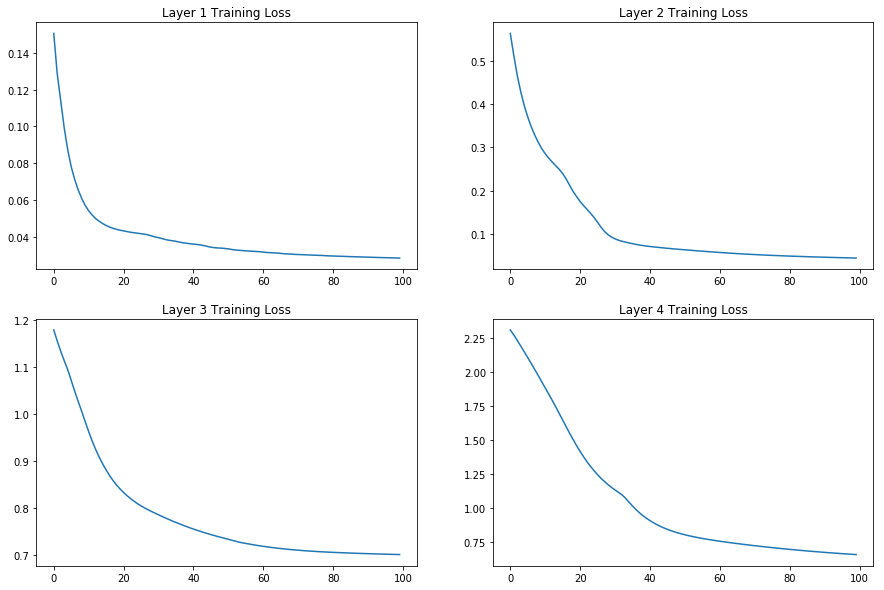

In [26]:
plot_loss_history(loss_hiss, pic_file="test")

### 4-4. Extract features from the datasets

In [47]:
feat_tr_compressed=encoder.predict(feat_tr)
feat_te_compressed=encoder.predict(feat_te)

### 4-5. Plot the data in 3D (Decrease dimentionality using PCA)

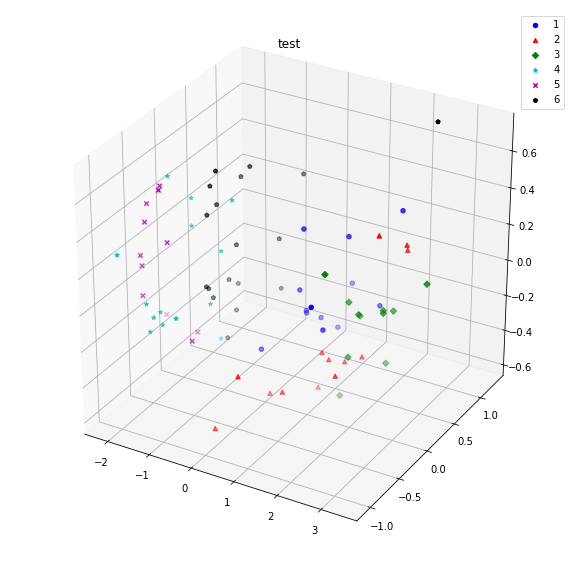

In [29]:
%matplotlib inline
PCA.pca(feat_tr_compressed, cls_tr, unique_labels, pic_file)

### 4-6. Train discriminative neural network
#### (1) Keral Multiclass classifier
This model is developed in reference to [Multi-Class Classification Tutorial with the Keras Deep Learning Library ](https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/).

In [287]:
def classifier(finetune=True):
    from keras.models import Sequential
    from keras.layers import Dense, Input

    model=Sequential()
    for e in encoder.layers:
        e.trainable=finetune
        model.add(e)
    model.add(Dense(30, input_dim=num_outs[-1], activation='relu'))
    model.add(Dense(6, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model

In [288]:
tmp=classifier(finetune=True)
tmp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_42 (Model)             (None, 562)               316406    
_________________________________________________________________
model_44 (Model)             (None, 562)               316406    
_________________________________________________________________
model_46 (Model)             (None, 562)               316406    
_________________________________________________________________
model_48 (Model)             (None, 55)                30965     
_________________________________________________________________
dense_445 (Dense)            (None, 30)                1680      
_________________________________________________________________
dense_446 (Dense)            (None, 6)                 186       
Total params: 982,049
Trainable params: 982,049
Non-trainable params: 0
_________________________________________________________________


In [229]:
from keras.utils import np_utils

# encode class values as integers
label_encoder=LabelEncoder()
encoded_Y=label_encoder.fit_transform(cls_tr)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [286]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

estimator=KerasClassifier(build_fn=classifier, finetune=False, epochs=10, batch_size=5, verbose=0)
results=cross_val_score(estimator, feat_tr, dummy_y, cv=10, verbose=1)#, n_jobs=-1)
print("Cross validation accuracy: Mean= %.2f, Std= %.2f" % (results.mean(), results.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_42 (Model)             (None, 562)               316406    
_________________________________________________________________
model_44 (Model)             (None, 562)               316406    
_________________________________________________________________
model_46 (Model)             (None, 562)               316406    
_________________________________________________________________
model_48 (Model)             (None, 55)                30965     
_________________________________________________________________
dense_425 (Dense)            (None, 30)                1680      
_________________________________________________________________
dense_426 (Dense)            (None, 6)                 186       
Total params: 982,049
Trainable params: 1,866
Non-trainable params: 980,183
_________________________________________________________________


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_42 (Model)             (None, 562)               316406    
_________________________________________________________________
model_44 (Model)             (None, 562)               316406    
_________________________________________________________________
model_46 (Model)             (None, 562)               316406    
_________________________________________________________________
model_48 (Model)             (None, 55)                30965     
_________________________________________________________________
dense_441 (Dense)            (None, 30)                1680      
_________________________________________________________________
dense_442 (Dense)            (None, 6)                 186       
Total params: 982,049
Trainable params: 1,866
Non-trainable params: 980,183
_________________________________________________________________


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   45.6s finished


### 2-4. Classification with other procedures

#### (1) Decision Tree

In [ ]:
title = "%s_Decision_Tree (%d)" % (pic_file, len(X))
true_label, pred_label, clf = CLS.train (feat_te_compressed, cls_te, 0, 0)
CLS.plot_confusion_matrix(true_label, pred_label, unique_labels, pic_file, title, "Decision_Tree")
clf

#### (2) Naive Bayes

In [ ]:
title = "%s_Naive Bayes (%d)" % (pic_file, len(X))
true_label, pred_label, clf = CLS.train (feat_te_compressed, cls_te, 1, 0)
CLS.plot_confusion_matrix(true_label, pred_label, unique_labels, pic_file, title, "Naive Bayes")
clf

#### (3) SVM

In [ ]:
title = "%s_SVM (%d)" % (pic_file, len(X))
true_label, pred_label, clf = CLS.train (feat_te_compressed, cls_te, 2, data_id)
CLS.plot_confusion_matrix(true_label, pred_label, unique_labels, pic_file, title, "SVM")
clf